
#Lab6 : Word Sense Disambiguation

Authors:<br>
* Ramón Mateo Navarro
* Benet Manzanares Salor

##Installation ans imports

In [1]:
import os
import pandas as pd
import nltk

from argparse import Namespace
from google.colab import drive
from scipy.stats import pearsonr
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
     |████████████████████████████████| 66 kB 3.9 MB/s 


## Settings


In [ ]:
settings = Namespace()

settings.mount_path = "/content/drive/"
drive.mount(settings.mount_path, force_remount=True)

settings.project_folder = "/content/drive/MyDrive/Benet_MAI/S1/IHLT/IHLT_Labs/Lab6" #@param ["/content/drive/MyDrive/MAI/IHLT/IHTL_Labs/Lab6/STS.input.SMTeuroparl.txt", "/content/drive/MyDrive/Benet_MAI/S1/IHLT/IHLT_Labs/Lab6" ]
settings.project_path = os.path.join(os.path.join(settings.mount_path, "MyDrive"), settings.project_folder)
settings.input_filename = "STS.input.SMTeuroparl.txt" #@param {type:"string"}
settings.input_filepath = os.path.join(settings.project_path, settings.input_filename)
settings.gs_filename = "STS.gs.SMTeuroparl.txt" #@param {type:"string"}
settings.gs_filepath = os.path.join(settings.project_path, settings.gs_filename)

Mounted at /content/drive/


## Data

In [ ]:
dt = pd.read_csv(settings.input_filepath,sep='\t', header=None)
dt['gs'] = pd.read_csv(settings.gs_filepath, sep='\t', header=None)
dt.head()

,0,1,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## Experiment

In [ ]:
wnl = WordNetLemmatizer()
PoS_to_WN_dict = {    
    "NN": "n",
    "NNS": "n",
    "NNP": "n",
    "NNPS": "n",
    "VB": "v",
    "VBD": "v",
    "VBG": "v",
    "VBN": "v",
    "VBP": "v",
    "VBZ": "v",
    "RB": "r",
    "RBR": "r",
    "RBS": "r",
    "JJ": "a",
    "JJR": "a",
    "JJS": "a",
}

In [ ]:
def lemmatize(p):
    if p[1][0] in PoS_to_WN_dict.keys():
        return wnl.lemmatize(p[0].lower(), pos=p[1][0].lower())
    return p[0]


def get_lemmas(sentence):
  words = nltk.word_tokenize(sentence)
  tags = nltk.pos_tag(words)
  lemmas = [lemmatize(pair) for pair in tags]
  return lemmas, tags


def get_post(sentence):
  words = nltk.word_tokenize(sentence)
  tags = nltk.pos_tag(words)
  lemmas = [lemmatize(pair) for pair in tags]
  return tags


def get_synsets(lemmas, tags):
  synsets = []
  for i in range(len(lemmas)):
    lemma = lemmas[i]
    if(tags[i][1] in PoS_to_WN_dict.keys()):
      synset = nltk.wsd.lesk(lemmas, lemma, PoS_to_WN_dict[tags[i][1]])
      if synset is not None:
        synsets.append(synset)

  return synsets

In [ ]:
def words_jaccard_similarity(sentences):
  sent1, sent2 = sentences
  words1 = set(nltk.word_tokenize(sent1))
  words2 = set(nltk.word_tokenize(sent2))
  return 1-jaccard_distance(words1, words2)


def lemmas_jaccard_similarity(sentences):
  sent1, sent2 = sentences
  lemmas1, tags1 = get_lemmas(sent1)
  lemmas2, tags2 = get_lemmas(sent2)

  return 1 - jaccard_distance(set(lemmas1), set(lemmas2))
  

def synset_jaccard_similarity(sentences):
  sent1, sent2 = sentences
  lemmas1, tags1 = get_lemmas(sent1)
  lemmas2, tags2 = get_lemmas(sent2)
  synsets1 = get_synsets(lemmas1, tags1)
  synsets2 = get_synsets(lemmas2, tags2)
  distance = 1
  if synsets1 or synsets2:
    distance = 1 - jaccard_distance(set(synsets1), set(synsets2))
  
  return distance


dt["words_jaccard"] = list(map(words_jaccard_similarity, zip(dt[0], dt[1])))
dt["lemmas_jaccard"] = list(map(lemmas_jaccard_similarity, zip(dt[0], dt[1])))
dt["synsets_jaccard"] = list(map(synset_jaccard_similarity, zip(dt[0], dt[1])))
dt.head()

,0,1,gs,words_jaccard,lemmas_jaccard,synsets_jaccard
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50,0.346154,0.346154,0.214286
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00,0.785714,0.785714,0.666667
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25,0.391304,0.391304,0.333333
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50,0.545455,0.545455,0.750000
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00,1.000000,1.000000,1.000000


## Results

In [ ]:
gs_words_correlation = pearsonr(dt['gs'], dt['words_jaccard'])[0]
gs_lemmas_correlation = pearsonr(dt['gs'], dt['lemmas_jaccard'])[0]
gs_synsets_correlation = pearsonr(dt['gs'], dt['synsets_jaccard'])[0]

print(f"[ Gold Standard <-> Words Jaccard ] correlation = {gs_words_correlation}")
print(f"[ Gold Standard <-> Lemmas Jaccard ] correlation = {gs_lemmas_correlation}")
print(f"[ Gold Standard <-> Synsets Jaccard ] correlation = {gs_synsets_correlation}")

[ Gold Standard <-> Words Jaccard ] correlation = 0.4504977169318684
[ Gold Standard <-> Lemmas Jaccard ] correlation = 0.4504977169318684
[ Gold Standard <-> Synsets Jaccard ] correlation = 0.43311891350506376


## Conclusions
As can be seen, the obtained correlation of the Synsets-based jaccard similarity is lower than the resulting from the lemmas and words approaches. This difference is probably based on the amount of words that are not defined in Wordnet and the lemmatization and desambiguation errors. For the out-of-wordnet case, although it helps to remove stopwords, many important tokens such as named entities (unique names) are ignored, affecting the results. The image bellow ilustrates the word to synset mapping including some of those out-of-wordnet cases. <br><br>
On the other hand, the lemmatization and desambiguation errors causes that identical or equivalent are mapped to different synsets, damaging similarity. The lemmatization problem was also present for the lemmas-based approach, but the desambiguation adds new possible errors.

Screenshot showning the word, PoS tag and corresponding synset for the first words of the corpus:
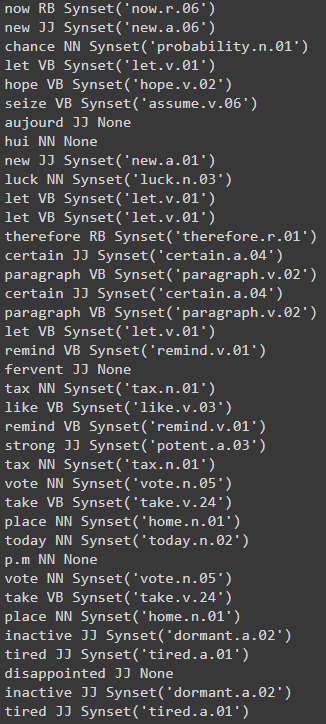